# **Physics-based loss and machine learing approach in application to fluids flow modelling: 2D flow domains**

The program recieves an image of the flow domain and the flow rate value, then calculate velocity distribution. The main idea is power loss minimization. The main unknown function is the stream function $\psi = \psi(x_1, x_2)$ that determines the velocity field $\textbf{V} = [[v_1, v_2]]$, where $v_1 = \frac{\partial \psi}{\partial x_2}$, $v_2 = - \frac{\partial \psi}{\partial x_1}$.



# Initialization
## Import libraries

In [1]:
# Pytorch modules
import torch
from torch import nn

# Plotting
from matplotlib import pyplot as plt
from matplotlib import transforms
import numpy as np

# Python functions
from collections import namedtuple
from itertools import product
from collections import OrderedDict
#from scipy import integrate

# Status bar
from tqdm.notebook import tqdm
from datetime import datetime
import time

# Work with files and images
import json
from pathlib import Path
import os, fnmatch
import re
from PIL import Image

#Log
import neptune.new as neptune
from neptune.new.types import File

import time

## Neptune project

In [2]:
run = neptune.init(
    project="avkornaev/PhysicsBasedDL",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRjMGY4Ny1hYTI1LTQxZmEtYjRmZC02YzNkYWZjYzNiNjIifQ==",
)  # your credentials

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`.
  This is separate from the ipykernel package so we can avoid doing imports until


https://app.neptune.ai/avkornaev/PhysicsBasedDL/e/PHYSIC-26
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Path

In [3]:
 path =  Path('/root/Physics_based_loss')
 imgPath = path/'ToyDataset'
 imgList = fnmatch.filter(os.listdir(imgPath), '*.png') #imgPath.ls()
 imgList

['Parallel plates narrow.png',
 'Parallel plates 1x16.png',
 'Parallel plates.png',
 'Nailfold_capillary.png',
 'Parallel plates 1x4.png',
 'Parallel plates with notch.png',
 'Parallel plates 1x4 with notch.png']

## Download and preprocess image of the flow domain

## Constants

In [4]:
#Training
SIZE = 256 # image size (128, 256, 512)
EPOCHS = 15000
NoOfFeatures = 32 #32
WORK_DIR = '/root/Physics_based_loss'
#SCALE_FACTOR = 1 # muliplier for the loss function
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "unet"
EARLY_STOP_PATIENCE = 5000
DECAY = 0

parameters = {'image_size':SIZE,
             'Epochs':EPOCHS,
             'Model':MODEL_NAME,
             'No_of_features':NoOfFeatures}

HYPS = []

hyps = {"learning_rate": [1e-4],
        "scheduler": ["none"],
        "scheduler_factor": [0.1],
        "scheduler_patience": [50],
        "use_bn": [True],
        "Early_stop_patience": [EARLY_STOP_PATIENCE],
        "Decay": [DECAY]} # Use or not batchnorm
    
for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})
#"scheduler": ["None", "step", "cycle"]
#"use_bn": [True, False]

#Visualization
sp = int(SIZE/2)#slice position
vps = 10 #vector plot step 
FIGSIZE = 5 # figure size
#S2 = int(SIZE*0.4)
#S3 = SIZE - S2
UP_COLOR  =  torch.tensor((0, 255, 0)) # upper wall color is green 
LOW_COLOR =  torch.tensor((0, 0, 255)) # upper wall color is blue
#CENTER_COLOR = torch.tensor((1, 1, 1)) # flow domain

## Log parameters

In [5]:
run["config/parameters"] = parameters
run["config/hyperparameters"] = hyps

/opt/conda/lib/python3.7/site-packages/neptune/new/attributes/attribute.py:64: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  return self.assign(value, wait)


## Geometry of the flow domain, fluid properties and boundary conditions
The fluid is Newtonian.
The domain of size *'L x L'*  with flow channel is represented as an image of size *'SIZE x SIZE'*. $S_1$ is the upper wall with the green label [0 255 0]. $S_2$ and $S_4$ are outlet and inlet surfaces, respectivelly. $S_3$ is the lower wall with the blue label [0 0 255]. No-slip condition is applied on the walls. The flow rate is given and equal to $Q$.

In [6]:
#Image number from the imgList
imgNo = 4

#read proporion from the title
regex = re.compile(r'\d+')
proportion = regex.findall(imgList[imgNo])

# L x L flow domain
L = 0.012#0.0024#
h = L/4 # h is thickness of the gap between 2 parallel plates when 'Parallel plates.png' is under study

# Normalized coordinates, finite diferences, limits and elementary surface area
X1N = torch.linspace(0, 1, SIZE)
X2N = torch.linspace(0, 1, SIZE)
DX1N = X1N[1] - X1N[0]
DX2N = X2N[1] - X2N[0]
LIM1 = [0, L]
LIM2 = [0, L]
ds = DX1N * DX2N * LIM1[1] * LIM2[1] # elementary surface area

# Flow rate through the inlet (outlet) boundary, m^3/s
Q = 5E-4#0.0000005#

# Koefficient of dynamic viscosity (viscosity), Pa*s
# Herschel-Bulkley model mu = q0 + q1*Eta^(z-1)
Q0 = 1e-3
Q1 = 0
Z = 1

MU = 1e-3 # 2.65e-3 
# Density, kg/m**3
RHO = 1000

#Mass force
Fm = [-1.18E-5/(h*L), 0]

## Additional functions

Numerical derivative

In [7]:
def num_diff_1(f, dx1, dx2):
    '''Numerical partial derivatives of a function of two variables f = f(x1, x2):
    i - index along x1
    j - index along x2
    for the internal points - central differences e.q. df_dx = (f_{i+1}-f_{i-1})/(2*dx)
    for the boundaries - left or right finite differences e.q. df_dx = (f_{i+1}-f_{i})/dx or df_dx = (f_{i}-f_{i-1})/dx
    '''
    n1, n2 = f.shape
    df_dx1 = 0
    df_dx2 = 0
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
    # x1 derivative:
    df_dx1[:, 1:n2-1] = (f[:, 2:] - f[:, :-2]) / (2 * dx1)
    df_dx1[:, 0] = (-f[:, 2] + 4 * f[:,1] - 3 * f[:,0]) / (2 * dx1)
    df_dx1[:, n2-1] = (3 * f[:,n2-1] - 4 * f[:,n2-2] + f[:,n2-3]) / (2 * dx1)
    # x2 derivative:
    df_dx2[1:n1-1, :] = (f[2:, :] - f[:-2,:]) / (2 * dx2)
    df_dx2[0, :] = (- f[2,:] + 4 * f[1,:] - 3 * f[0, :]) / (2 * dx2)
    df_dx2[n1-1, :] = (3 * f[n1 - 1, :] - 4 * f[n1 - 2, :] + f[n1 - 3, :]) / (2 * dx2)

    return df_dx1, df_dx2

In [8]:
def num_diff(f, dx1, dx2):
    '''Numerical partial derivatives of a function of two variables f = f(x1, x2):
    i - index along x1
    j - index along x2
    for the internal points - central differences e.q. df_dx = (f_{i+1}-f_{i-1})/(2*dx)
    for the boundaries - left or right finite differences e.q. df_dx = (f_{i+1}-f_{i})/dx or df_dx = (f_{i}-f_{i-1})/dx
    '''
    n1, n2 = f.shape
    df_dx1 = 0
    df_dx2 = 0
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
    # x1 derivative:
    df_dx1[:, 1:n2-1] = (-3*f[:, 0:n2-2] +4*f[:, 1:n2-1] - f[:, 2:n2]) / (2 * dx1)
    df_dx1[:, 0] = (3 * f[:,n2-1] - 4 * f[:,n2-2] + f[:,n2-3]) / (2*dx1)
    df_dx1[:, n2-1] = (3 * f[:,n2-2] - 4 * f[:,n2-3] + f[:,n2-4]) / (2*dx1)
    # x2 derivative:
    df_dx2[0:n1-2, :] = (-3*f[0:n1-2,:] +4*f[1:n1-1,:] - f[2:n1,:]) / (2 * dx2)
    df_dx2[n1-1, :] = (3 * f[n1-1,:] - 4 * f[n1-2,:] + f[n1-3,:]) / (2 * dx2)
    df_dx2[n1-2, :] = (3 * f[n1-2,:] - 4 * f[n1-3,:] + f[n1-4,:]) / (2 * dx2)

    return df_dx1, df_dx2

In [9]:
def num_diff_5_points(f, dx1, dx2):
    '''Numerical partial derivatives of a function of two variables f = f(x1, x2):
    i - index along x1
    j - index along x2
    for the internal points - central differences e.q. df_dx = (f_{i+1}-f_{i-1})/(2*dx)
    for the boundaries - left or right finite differences e.q. df_dx = (f_{i+1}-f_{i})/dx or df_dx = (f_{i}-f_{i-1})/dx
    '''
    n1, n2 = f.shape
    df_dx1 = 0
    df_dx2 = 0
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    d2f_dx1, d2f_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
        d2f_dx1 = df_dx1.to('cuda')
        d2f_dx2 = df_dx2.to('cuda')
    
      # 1st order x1 derivative:
    df_dx1[:, 2:n2-2] = (-f[:, 4:] + 8 * f[:, 3:n2-1] - 8 * f[:, 1:n2-3] + f[:, :n2-4]) / (12 * dx1)
    df_dx1[:, 0] = (-3 * f[:,4] + 16 * f[:, 3] - 36 * f[:, 2] + 48 * f[:, 1] - 25 * f[:,0]) / (12*dx1)
    df_dx1[:, 1] = (f[:,4] - 6 * f[:, 3] + 18 * f[:, 2] - 10 * f[:, 1] - 3 * f[:,0]) / (12*dx1)
    df_dx1[:, n2-2] = (3 * f[:, n2-1] + 10 * f[:, n2-2] - 18 * f[:, n2-3] + 6 * f[:, n2-4] - f[:,n2-5]) / (12*dx1)
    df_dx1[:, n2-1] = (25 * f[:, n2-1] - 48 * f[:, n2-2] + 36 * f[:, n2-3] - 16 * f[:, n2-4] + 3 * f[:,n2-5]) / (12*dx1)
      
      # 1st order x2 derivative:
    df_dx2[2:n1-2, :] = (-f[4:, :] + 8 * f[3:n1-1, :] - 8 * f[1:n1-3, :] + f[:n1-4, :]) / (12 * dx2)
    df_dx2[0, :] = (-3 * f[4, :] + 16 * f[3, :] - 36 * f[2, :] + 48 * f[1, :] - 25 * f[0, :]) / (12 * dx2)
    df_dx2[1, :] = (f[4, :] - 6 * f[3, :] + 18 * f[2, :] - 10 * f[1, :] - 3 * f[0, :]) / (12 * dx2)
    df_dx2[n1-2, :] = (3 * f[n1-1, :] + 10 * f[n1-2, :] - 18 * f[n1-3, :] + 6 * f[n1-4, :] - f[n1-5, :]) / (12 * dx2)
    df_dx2[n1-1, :] = (25 * f[n1-1, :] - 48 * f[n1-2, :] + 36 * f[n1-3, :] - 16 * f[n1-4, :] + 3*f[n1-5, :]) / (12 * dx2)

#     # 2nd order x1 derivative:
#     d2f_dx1[:, 2:n2-2] = (-f[:, 4:] + 16 * f[:, 3:n2-1] - 30 *f[:, 2:n2-2] + 16* f[:, 1:n2-3] - f[:, :n2-4]) / (12 * dx1**2)
#     d2f_dx1[:, 0] = (11 * f[:,4] - 56 * f[:, 3] + 114 * f[:, 2] - 104 * f[:, 1] + 35 * f[:,0]) / (12*dx1**2)
#     d2f_dx1[:, 1] = (-f[:,4] + 4 * f[:, 3] + 6 * f[:, 2] - 20 * f[:, 1] + 11 * f[:,0]) / (12*dx1**2)
#     d2f_dx1[:, n2-2] = (11 * f[:, n2-1] - 20 * f[:, n2-2] + 6 * f[:, n2-3] + 4 * f[:, n2-4] - f[:,n2-5]) / (12*dx1**2)
#     d2f_dx1[:, n2-1] = (35 * f[:, n2-1] - 104 * f[:, n2-2] + 114 * f[:, n2-3] - 56 * f[:, n2-4] + 11 * f[:,n2-5]) / (12*dx1**2)

#     # 2nd order x2 derivative:
#     d2f_dx2[2:n1-2, :] = (-f[4:, :] + 16 * f[3:n1-1, :] - 30 *f[2:n1-2, :] + 16* f[1:n1-3, :] - f[:n1-4, :]) / (12 * dx2**2)
#     d2f_dx2[0, :] = (11 * f[4, :] - 56 * f[3, :] + 114 * f[2, :] - 104 * f[1, :] + 35 * f[0, :]) / (12*dx2**2)
#     d2f_dx2[1, :] = (-f[4, :] + 4 * f[3, :] + 6 * f[2, :] - 20 * f[1, :] + 11 * f[0, :]) / (12*dx2**2)
#     d2f_dx2[n1-2, :] = (11 * f[n1-1, :] - 20 * f[n1-2, :] + 6 * f[n1-3, :] + 4 * f[n1-4, :] - f[n1-5, :]) / (12*dx2**2)
#     d2f_dx2[n1-1, :] = (35 * f[n1-1, :] - 104 * f[n1-2, :] + 114 * f[n1-3, :] - 56 * f[n1-4, :] + 11 * f[n1-5, :]) / (12*dx2**2)

    return df_dx1, df_dx2

Check numerical differentiations

In [10]:
xx = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(xx, xx)

dxx = xx[1][0]-xx[0][0]
zz = xx**3 + yy**3

diffzz = 3*xx**2 + 3*yy**2
diff1, diff2 = num_diff_5_points(zz, dxx, dxx) 
diffzz_= diff1 + diff2

intzz1 = torch.trapz(diffzz)*dxx
intzz2 = torch.trapz(intzz1)*dxx

intzz1_ = torch.trapz(diffzz_)*dxx
intzz2_ = torch.trapz(intzz1_)*dxx

print(f'exact solution {intzz2}, approximate solution {intzz2_}')

exact solution 2.0001022815704346, approximate solution 2.0001018047332764


Numerical integrals: single and double can be implemented by torch.trapezoid function https://pytorch.org/docs/stable/generated/torch.trapezoid.html#torch.trapezoid

Visualization

In [11]:
def vector_plot(arg, vec, FIGSIZE, vptitle='vector_plot',step=10):
    gradmag = np.sqrt(vec[0]**2+vec[1]**2)
    plt.pcolor(arg[0], arg[1], gradmag, cmap='rainbow')
    plt.colorbar()
    plt.quiver(arg[0][::step,::step], arg[1][::step,::step], vec[0][::step,::step], vec[1][::step,::step])
    plt.title(vptitle)
 

Color filter

In [12]:
# def colorFilter(img, color):
#     white = (255,255,255,255)
#     black = (0,0,0,255)
#     width,heigth = img.size
#     for i in range(width):
#         for j in range(heigth):
#             if img.getpixel((i,j)) == color:
#                 img.putpixel((i,j),black)
#         else:
#             #print(img.getpixel((i,j)))
#             img.putpixel((i,j),white)
#     return img

# def inverseColorFilter(img, color):
#     white = (255,255,255,255)
#     black = (0,0,0,255)
#     width,heigth = img.size
#     for i in range(width):
#         for j in range(heigth):
#             if img.getpixel((i,j)) == color:
#                 img.putpixel((i,j),white)
#         else:
#             #print(img.getpixel((i,j)))
#             img.putpixel((i,j),black)
#     return img

## Major functions

Distributions: the velocity components [[$v_1$, $v_2$]], the strain rate tensor components [[$\xi_{ij}$]], $\xi_{ij}=\xi_{ji}$ . And the shear rate intensity Η. 

In [13]:
def velocityDistr(psi,dx1n,dx2n,lim1,lim2):
    '''Velocity distribution [[v1, v2]] in the flow domain
    '''
    n = psi.shape
    v1 = 0
    v2 = 0
    dpsidx1 = 0
    dpsidx2 = 0
    dpsidx1, dpsidx2 = num_diff_5_points(psi, dx1n, dx2n)
    v1 = dpsidx2 / lim2[1]
    v2 = - dpsidx1 / lim1[1]
    
    return v1,v2

In [14]:
def TksiDistr(v1,v2,dx1n,dx2n,lim1,lim2):
    '''Strain rate tensor Txi and the shear rate intensity Eta squared
    '''    
    n = v1.shape
    xi11 = 0
    xi12 = 0
    xi22 = 0
    dv1dx1 = 0
    dv1dx2 =0
    dv2dx1 = 0
    dv2dx2 = 0
  
    dv1dx1, dv1dx2 = num_diff_5_points(v1, dx1n, dx2n)
    dv2dx1, dv2dx2 = num_diff_5_points(v2, dx1n, dx2n)
  
    xi11 = dv1dx1 / lim1[1]
    xi12 = 0.5 * (dv1dx2 / lim2[1] + dv2dx1 / lim1[1])
    xi22 = dv2dx2 / lim2[1]
    EtaEta = (2 * (xi11 * xi11 + 2* xi12 * xi12 + xi22 * xi22))
  
    return xi11, xi12, xi22, EtaEta

## Callbacks

In [15]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

## Training function

In [16]:
def train(model, inp, optimizer,
          criterion, epochs, print_every, callbacks, lr_scheduler):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        inp (Tensor): Inpu image.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    history = {'Train loss':[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    train_print = ''
    state_text_last = ''
    bar = tqdm(range(epochs), desc="Epoch", postfix=train_print)
    for e in range(epochs):
        model.train()

        running_loss = 0

        stop = False
        
        steps = 0
        
        optimizer.zero_grad()
        
        out = model.forward(inp)
            
        loss = criterion(out)
        run["training/batch/loss_training"].log(loss)

        loss.backward()
                
        optimizer.step()
            
        with torch.no_grad():
            running_loss = loss.item()
        
        if (e + 1) % print_every == 0:
            print(f'epoch {e+1}/{epochs}, loss = {running_loss:.4f}')
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            model.train()
            
        
        history['Train loss'].append(running_loss)
        
        if lr_scheduler:
            if "OneCycleLR" in str(lr_scheduler):
                lr_scheduler.step()
            else:
                lr_scheduler.step(running_loss)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    state_text_last = state_text
                if state:
                    stop = True
        if stop:
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            inputs = None
            targets = None
            outputs = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
            
        if e + 1 != epochs:
            bar.update()
                        
        inputs = None
        targets = None
        outputs = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()
      
    bar.update()
    bar.close()
    
    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history


def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train loss'], c = 'r')
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()

    
def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

# Asymptotic solution: flow between two parallel plates
Newtonian fluid flow between 2 parallel plates, the flow domain size is hxL

h = 0.003 ; L= 0.012 ; (p1-p0) = -2.666666666666667 ; v1max = tensor(0.2500) 
mu =  0.001 Q =  0.0005 
Ext_ex = -0.0013333333333333335 
Int = tensor(0.0013, device='cuda:0') 
Re = tensor(749.9972)


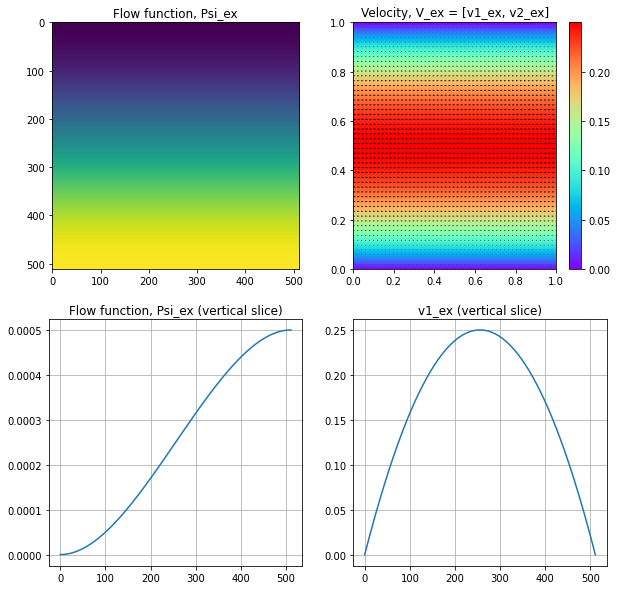

In [17]:
#Exact solution

C0 = -12*MU*Q/(h**3)
C1 = 6*Q/(h**2)
psiex = C0*(X2N**3)*h**3/(6*MU) + C1*(X2N**2/2)*h**2
v1ex = C0*(X2N**2)*h**2/(2*MU) + C1*(X2N)*h
v1exmax = v1ex[int(SIZE/2)] 

pressureDrop = C0*L
Ext_ex = pressureDrop * Q

# From 1D to 2D
psiex = psiex * torch.ones(SIZE, SIZE)
psiex = psiex.t()

v1ex = v1ex * torch.ones(SIZE, SIZE)
v1ex = v1ex.t()

v2ex = torch.zeros(SIZE, SIZE)

#Calculate Internal power to check numerical integration
lim1 = [0, L]
lim2 = [0, h]

xi11, xi12, xi22, EtaEta = TksiDistr(v1ex, v2ex, DX1N, DX2N, lim1, lim2)
#Int_ex is a double integral. It's calculation can be done in 2 steps: in 2 single integrations
int1EtaEta = torch.trapz(EtaEta)
int2EtaEta = torch.trapz(int1EtaEta)
ds_ex = DX1N * DX2N * lim1[1] * lim2[1] # elementary surface area
Int_ex = MU*ds_ex*int2EtaEta #doublelIntegral

Re = RHO*v1ex.max()*h/MU

print('h =', h, '; L=', L, '; (p1-p0) =', pressureDrop,'; v1max =', v1exmax, 
      '\nmu = ', MU, 'Q = ', Q, 
      '\nExt_ex =', Ext_ex, 
      '\nInt =', Int_ex,
      '\nRe =', Re)

#Visualization
nr=2
nc=2
fig = plt.figure(figsize=(FIGSIZE*nr, FIGSIZE*nc))
plt.title('Asymptotic solution: Newtonian flow between 2 parallel plates in the flow domain h x L')
plt.subplot(nr,nc,1)
plt.imshow(psiex)
plt.title('Flow function, Psi_ex')

plt.subplot(nr,nc,2)
vector_plot(np.meshgrid(X1N,X2N), [np.array(v1ex),np.array(v2ex)],FIGSIZE, 'Velocity, V_ex = [v1_ex, v2_ex]', vps)

plt.subplot(nr,nc,3)
plt.plot(psiex[:,sp])
plt.grid(True)
plt.title('Flow function, Psi_ex (vertical slice)')

plt.subplot(nr,nc,4)
plt.plot(v1ex[:,sp])
plt.grid(True)
plt.title('v1_ex (vertical slice)')

plt.show()
    

In [18]:
L/16

0.00075

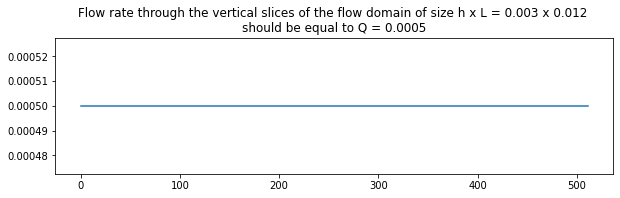

In [19]:
# Check the flow rate
Qex = torch.trapz(v1ex.t()) * DX1N * h

fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(Qex.cpu())
plt.title(f'Flow rate through the vertical slices of the flow domain of size h x L = {h:.4} x {L} \nshould be equal to Q = {Q}')
plt.show()

tensor(0.4208) tensor(111155.3906)


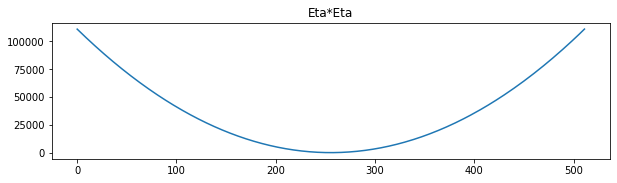

In [20]:
print (EtaEta.cpu().min(), EtaEta.cpu().max()) 

fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(EtaEta.cpu()[:,sp])
plt.title('Eta*Eta')
plt.show()

# Machine learning solution
## Flow domain mask

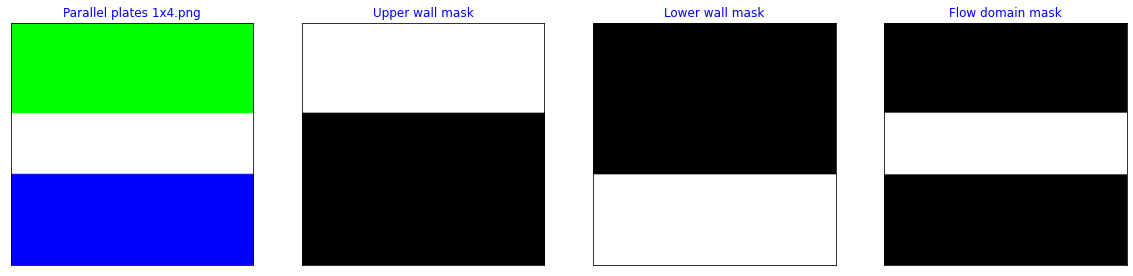

Check the masks: 
upper wall (min, max) = (tensor(0.), tensor(1.)), 
lower wall (min, max) = (tensor(0.), tensor(1.)), 
flow domain (min, max) = (tensor(0.), tensor(1.)),


In [21]:
labeledImage = Image.open(imgPath/imgList[imgNo]) #open image
labeledImage = torch.tensor(np.uint8(labeledImage.resize((SIZE,SIZE),resample=3)))[:,:,:-1] #open image

tmpImage = torch.ones(labeledImage.shape)

upperWallMask = (labeledImage == (tmpImage*UP_COLOR)).float().sum(axis=2)
invUpperWallMask = torch.clone(upperWallMask)
upperWallMask[upperWallMask < 3] = 0
upperWallMask[upperWallMask == 3] = 1
invUpperWallMask[invUpperWallMask < 3] = 1
invUpperWallMask[invUpperWallMask == 3] = 0

lowerWallMask = (labeledImage == (tmpImage*LOW_COLOR)).float().sum(axis=2)
invLowerWallMask = torch.clone(lowerWallMask)
lowerWallMask[lowerWallMask < 3] = 0
lowerWallMask[lowerWallMask == 3] = 1
invLowerWallMask[invLowerWallMask < 3] = 1
invLowerWallMask[invLowerWallMask == 3] = 0

flowDomainMask = (invLowerWallMask + invUpperWallMask)/2
flowDomainMask[flowDomainMask<1] = 0

#Visualization
nr=1
nc=4
fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
plt.subplot(nr,nc,1)
plt.imshow(labeledImage)
plt.xticks([])
plt.yticks([])
plt.title(imgList[imgNo], color='b')

plt.subplot(nr,nc,2)
plt.imshow(upperWallMask, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Upper wall mask", color='b')

plt.subplot(nr,nc,3)
plt.imshow(lowerWallMask, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Lower wall mask", color='b')

plt.subplot(nr,nc,4)
plt.imshow(flowDomainMask, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Flow domain mask", color='b')

plt.show()

print (f'Check the masks: \nupper wall (min, max) = {upperWallMask.min(), upperWallMask.max()}, \nlower wall (min, max) = {lowerWallMask.min(), lowerWallMask.max()}, \nflow domain (min, max) = {flowDomainMask.min(), flowDomainMask.max()},')

In [22]:
labeledImage[sp,0,:]

tensor([255, 255, 255], dtype=torch.uint8)

## Kinematic properties
The velocity is equal to zero on all the surfaces. The flow rate is given and equal to Q.

1. Flow function initialization

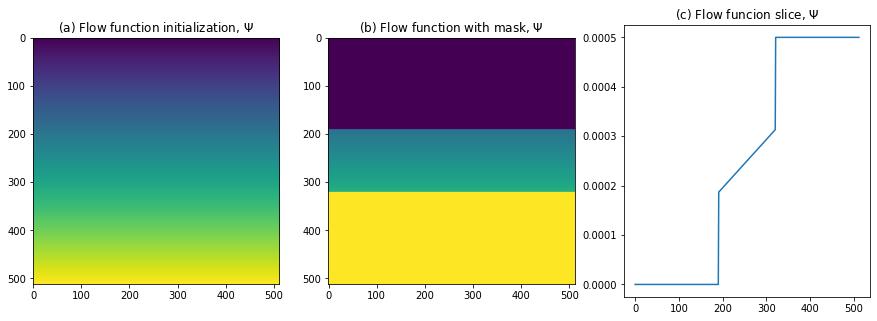

In [23]:
#Initialization
#psi0 = (torch.linspace(Q * 4, 0,SIZE, dtype=torch.float32) * torch.ones(SIZE,SIZE)).T - 1.5 * Q #raw Psi0 function
psi0 = (torch.linspace(0, Q, SIZE, dtype=torch.float32) * torch.ones(SIZE,SIZE)).T #raw Psi0 function
#psi0_masked = (psi0 * wall_mask) + (upper_mask * Q)# Psi0 function with mask
psi0_masked = psi0 *flowDomainMask + (lowerWallMask*Q)

#Visualization
nr=1
nc=3
fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
plt.subplot(nr,nc,1)
plt.imshow(psi0)
plt.title('(a) Flow function initialization, $\Psi$')

plt.subplot(nr,nc,2)
plt.imshow(psi0_masked)
plt.title('(b) Flow function with mask, $\Psi$')

plt.subplot(nr,nc,3)
plt.plot(psi0_masked[:,sp])
plt.title('(c) Flow funcion slice, $\Psi$')

plt.show()

2. Velocity field initialization

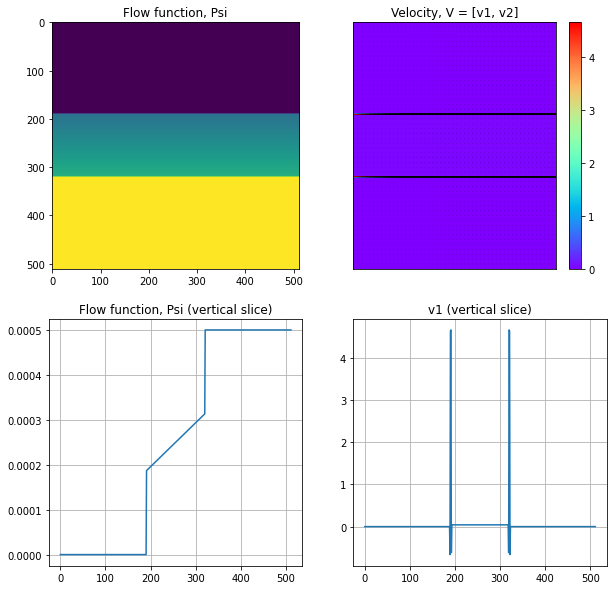

In [24]:
v1, v2 = velocityDistr(psi0_masked, DX1N, DX2N, LIM1, LIM2)

#Visualization
nr=2
nc=2
fig = plt.figure(figsize=(FIGSIZE*nr, FIGSIZE*nc))
plt.subplot(nr,nc,1)
plt.imshow(psi0_masked)
plt.title('Flow function, Psi')

plt.subplot(nr,nc,2)
#coordinates are negative in meshgrid for the better visualisation
vector_plot(np.meshgrid(-X1N,-X2N), [np.array(v1.cpu()),np.array(v2.cpu())],FIGSIZE, 'Velocity, V = [v1, v2]', vps)
plt.xticks([])
plt.yticks([])

plt.subplot(nr,nc,3)
plt.plot(psi0_masked[:,sp])
plt.grid(True)
plt.title('Flow function, Psi (vertical slice)')

plt.subplot(nr,nc,4)
plt.plot(v1[:,sp].cpu())
plt.grid(True)
plt.title('v1 (vertical slice)')

plt.show()

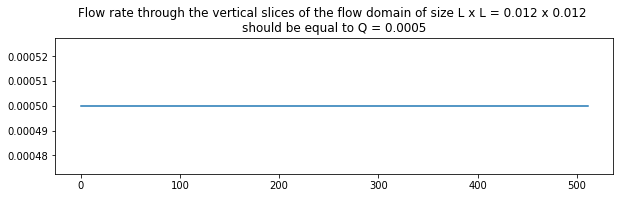

In [25]:
# Check the flow rate
Qch = torch.trapz(v1.t()) * DX1N * L

fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(Qch.cpu())
plt.title(f'Flow rate through the vertical slices of the flow domain of size L x L = {L} x {L} \nshould be equal to Q = {Q}')
plt.show()

## Create model
Unet architecture [2] is used

In [26]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4, use_bn=True):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1", use_bn=use_bn)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2", use_bn=use_bn)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3", use_bn=use_bn)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4", use_bn=use_bn)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck", use_bn=use_bn)

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4", use_bn=use_bn)
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3", use_bn=use_bn)
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2", use_bn=use_bn)
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1", use_bn=use_bn)
        self.decoder0 = UNet._block(features, features, name="dec1", use_bn=use_bn)
        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec0 = self.decoder0(dec1)
        return torch.sigmoid(self.conv(dec0))*Q

    @staticmethod
    def _block(in_channels, features, name, use_bn):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm1", nn.BatchNorm2d(num_features=features)),
                      (name + "relu1", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm2", nn.BatchNorm2d(num_features=features)),
                      (name + "relu2", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                ]
            )
        )
    
def power_loss(psi):
    psi_masked = (psi[0,0,:,:] * flowDomainMask) + (lowerWallMask * Q)
    v1,v2 = velocityDistr(psi_masked, DX1N, DX2N, LIM1, LIM2)

    xi11, xi12, xi22, EtaEta = TksiDistr(v1, v2, DX1N, DX2N, LIM1, LIM2)
    
    int1EtaEta = torch.trapz(EtaEta + v1*Fm[0]+v2*Fm[1])
    int2EtaEta = torch.trapz(int1EtaEta)
    out = 0.5*MU*s*int2EtaEta #doublelIntegral(0.5*mu*EtaEta,lim1,lim2) #loss
    
    return out #0.5 * MU * s * EtaEta.mean()

## Training

In [27]:
start_time = time.time()

hyperparams: 
 learning_rate 0.0001, scheduler none, scheduler_factor 0.1, scheduler_patience 50, use_bn True, Early_stop_patience 5000, Decay 0


Epoch:   0%|          | 0/15000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 100/15000, loss = 1.5692
epoch 200/15000, loss = 0.7313
epoch 300/15000, loss = 0.4304
epoch 400/15000, loss = 0.3034
epoch 500/15000, loss = 0.2328
epoch 600/15000, loss = 0.1858
epoch 700/15000, loss = 0.1538
epoch 800/15000, loss = 0.1310
epoch 900/15000, loss = 0.1141
epoch 1000/15000, loss = 0.1009
epoch 1100/15000, loss = 0.0904
epoch 1200/15000, loss = 0.0824
epoch 1300/15000, loss = 0.0744
epoch 1400/15000, loss = 0.0712
epoch 1500/15000, loss = 0.0624
epoch 1600/15000, loss = 0.0585
epoch 1700/15000, loss = 0.0796
epoch 1800/15000, loss = 0.0571
epoch 1900/15000, loss = 0.0495
epoch 2000/15000, loss = 0.0451
epoch 2100/15000, loss = 0.0432
epoch 2200/15000, loss = 0.0383
epoch 2300/15000, loss = 0.0357
epoch 2400/15000, loss = 0.0329
epoch 2500/15000, loss = 0.0339
epoch 2600/15000, loss = 0.0292
epoch 2700/15000, loss = 0.0278
epoch 2800/15000, loss = 0.0280
epoch 2900/15000, loss = 0.0248
epoch 3000/15000, loss = 0.0236
epoch 3100/15000, loss = 0.0268
epoch 3200/15000,

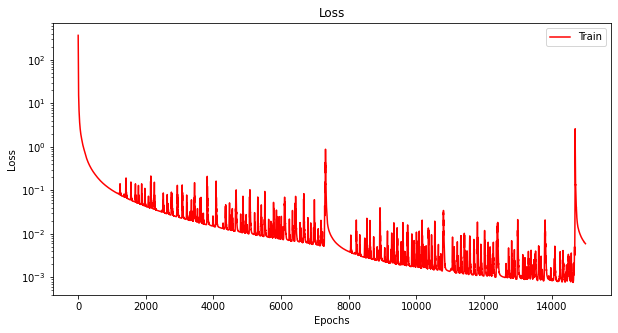

Final loss: 0.001
simulation time:94m 4s


In [28]:
os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

x = torch.ones((1, 1, SIZE, SIZE)) * psi0_masked
s = DX1N * DX2N * LIM1[1] * LIM2[1]

# Перемещение на GPU
x = x.to(DEVICE)
flowDomainMask = flowDomainMask.to(DEVICE)
lowerWallMask = lowerWallMask.to(DEVICE)
DX1N = DX1N.to(DEVICE)
DX2N = DX2N.to(DEVICE)
s = s.to(DEVICE)

run_record = {}

for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp)) 

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}.pth')

    callbacks = [SaveBest(f'Train loss', model_path, 'min'),
                 EarlyStop(f'Train loss', EARLY_STOP_PATIENCE, 'min')]

    model = UNet(in_channels=1, out_channels=1, init_features=NoOfFeatures, use_bn=hyp["use_bn"])
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=hyp["learning_rate"], weight_decay=DECAY)
    
    criterion = power_loss
    
    #Log model, criterion, and optimizer
    run["config/model"] = type(model).__name__
    run["config/criterion"] = type(criterion).__name__
    run["config/optimizer"] = type(optimizer).__name__

    
    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                  patience=hyp["scheduler_patience"],
                                                                  min_lr=1e-6, factor=hyp["scheduler_factor"])
    elif hyp["scheduler"] == "cycle":
        lr_scheduler = scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hyp["learning_rate"] * 20,
                                                                       steps_per_epoch=1, epochs=EPOCHS,
                                                                       pct_start=0.125,
                                                                       div_factor=hyp["scheduler_factor"] ** -1,
                                                                       final_div_factor=(hyp["scheduler_factor"] ** -1) * 50)
    else:
        lr_scheduler = None

    history = train(model, x, optimizer, power_loss,
                    epochs=EPOCHS, print_every=100,
                    callbacks=callbacks, lr_scheduler=lr_scheduler)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_val_metric': callbacks[1].best_monitor}

    print(f"Best Train loss %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_val_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_val_metric is None or best_val_metric > train_info['final_val_metric']:
        best_val_metric = train_info['final_val_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best Train loss: %4.4f, best hyperparams: %s" % (best_val_metric, best_hyp))

model = UNet(in_channels=1, out_channels=1, init_features=NoOfFeatures, use_bn=best_hyperparams["use_bn"])
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')

model = model.to(DEVICE)

psi = model.forward(x)

plot_train_history(best_run['history'])

simulation_time = time.time() - start_time
print(f'Final loss: {power_loss(psi).cpu().item() :.3f}')
print('simulation time:{:.0f}m {:.0f}s'.format(
      simulation_time // 60, simulation_time % 60))

## Results

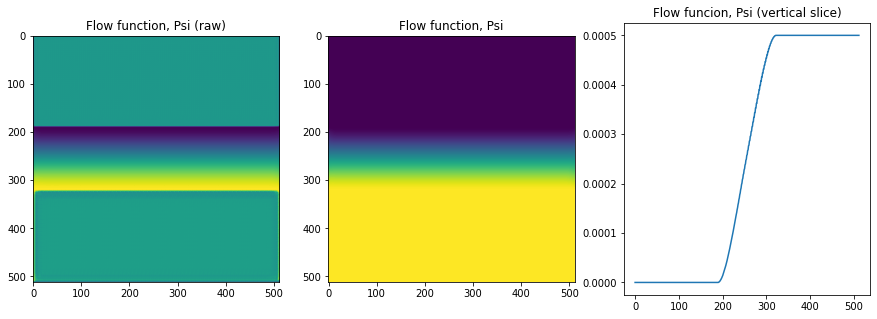

In [29]:
#Output of the network: psi function of the flow

psi_masked = (psi[0, 0, :, :].clone().detach() * flowDomainMask) + (lowerWallMask * Q)
v1, v2 = velocityDistr(psi_masked, DX1N, DX2N, LIM1, LIM2)
xi11ch, xi12ch, xi22ch, EtaEtach = TksiDistr(v1, v2, DX1N, DX2N, LIM1, LIM2)
int1EtaEta = torch.trapz(EtaEtach)
int2EtaEta = torch.trapz(int1EtaEta)
outch = 0.5*MU*s*int2EtaEta


#Visualization
nr=1
nc=3
fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
plt.subplot(nr,nc,1)
plt.imshow(psi[0, 0, :, :].clone().detach().to('cpu'))
plt.title('Flow function, Psi (raw)')

plt.subplot(nr,nc,2)
plt.imshow(psi_masked.to('cpu'))
plt.title('Flow function, Psi')

plt.subplot(nr,nc,3)
plt.plot(psi_masked[:,sp].to('cpu'))
plt.title('Flow funcion, Psi (vertical slice)')

plt.show()

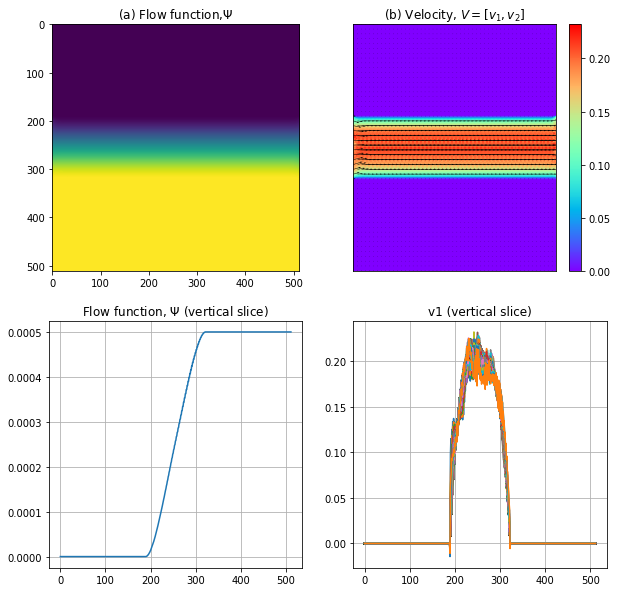

v1_max =  tensor(0.2320, device='cuda:0') v1_min =  tensor(-0.0145, device='cuda:0')


In [30]:
#Visualization
nr=2
nc=2
fig = plt.figure(figsize=(FIGSIZE*nr, FIGSIZE*nc))
plt.subplot(nr,nc,1)
plt.imshow(psi_masked.to('cpu'))
plt.title('(a) Flow function,$\Psi$')

plt.subplot(nr,nc,2)
vector_plot(np.meshgrid(-X1N,-X2N), [np.array(v1.cpu()),np.array(v2.cpu())],FIGSIZE, 
            '(b) Velocity, $V = [v_1, v_2]$', 10)
plt.xticks([])
plt.yticks([])

plt.subplot(nr,nc,3)
plt.plot(psi_masked[:,sp].to('cpu'))
plt.grid(True)
plt.title('Flow function, $\Psi$ (vertical slice)')

plt.subplot(nr,nc,4)
plt.plot(v1.cpu())
plt.grid(True)
plt.title('v1 (vertical slice)')

plt.show()
print('v1_max = ', v1.max(), 'v1_min = ', v1.min())

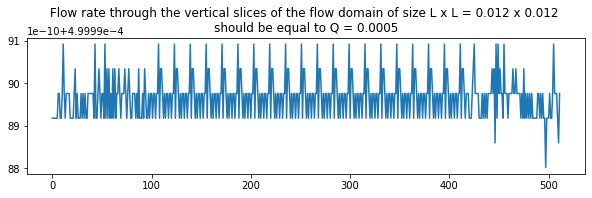

In [31]:
# Check the flow rate
Qch = torch.trapz(v1.t()) * DX1N * L

fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(Qch.cpu())
plt.title(f'Flow rate through the vertical slices of the flow domain of size L x L = {L} x {L} \nshould be equal to Q = {Q}')
plt.show()

In [32]:
print('Q = ', Qch.mean().cpu().item(), '; Loss = ', power_loss(psi).cpu().item())

Q =  0.0004999989178031683 ; Loss =  0.0007665370358154178


In [33]:
print (EtaEta.cpu().min(), EtaEta.cpu().max(), EtaEtach.cpu().min(), EtaEtach.cpu().max()) 
print(outch)


tensor(0.4208) tensor(111155.3906) tensor(0.) tensor(15843247.)
tensor(0.0008, device='cuda:0')


tensor(0.4208) tensor(111155.3906) tensor(0.) tensor(273970.1875)


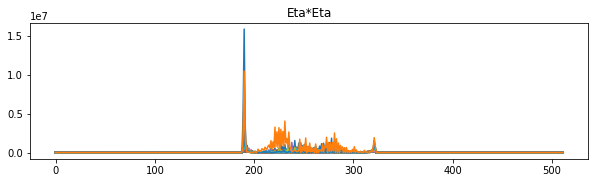

In [34]:

print (EtaEta.cpu().min(), EtaEta.cpu().max(), EtaEtach.cpu()[:,sp].min(), EtaEtach.cpu()[:,sp].max()) 
fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(EtaEtach.cpu())
plt.title('Eta*Eta')
plt.show()

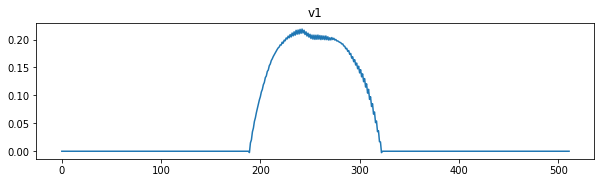

In [35]:
fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(v1.cpu()[:,sp])
plt.title('v1')
plt.show()

In [36]:
 #Check power
Intch = power_loss(psi).cpu().item()*2
Intch, Int_ex.item(), (Int_ex.item()-Intch)/Int_ex.item()

(0.0015330740716308355, 0.0013333443785086274, -0.1497960289491075)

## Stop logging

In [37]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/avkornaev/PhysicsBasedDL/e/PHYSIC-26


# Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch

In [38]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra